In [ ]:
function plot_kdist_graph(p_snnmat::SparseMatrixCSC{Float64, Int64}, k)
    kdist_arr = Float64[];

    for i in collect(1:size(p_snnmat,2))
        #Q = DataStructures.PriorityQueue(Int64, Float64, Base.Order.Reverse); # Base.Order.Reverse -> highest to lowest
        Q = DataStructures.PriorityQueue{Int64, Float64}(Base.Order.Reverse);
        nnzindices_i = p_snnmat[:,i].nzind;
        for j in nnzindices_i
            Q[j] = p_snnmat[j,i];#append similarity
        end
        c = 1;
        xx = 0;
        while c < k && length(Q) > 0 # k-th extracted item will be the k-th lowest similarity (~ k-th highest distance)
            xx = DataStructures.peek(Q)[2];
            DataStructures.dequeue!(Q);
            c += 1;
        end

        push!(kdist_arr, 1.0 - xx);
    end
    sort!(kdist_arr, rev=true); # desc order of distances 
    
    return kdist_arr
end

## DIstributed Shared Nearest Neighbor experiments

In [2]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end

#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",])
#addprocs(["158.251.93.5:3308","158.251.93.5:3307","158.251.93.5:3306","158.251.93.5:3305",
#        "158.251.93.5:3304","158.251.93.5:3303","158.251.93.5:3302","158.251.93.5:3301",])

addprocs(["158.251.88.180:3301","158.251.88.180:3302","158.251.88.180:3303","158.251.88.180:3304",])

@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
@everywhere include("/workspace/distributed_clustering/julia/src/dsnn_Master.jl")

using PyCall
@pyimport clustering_scores as cs #clustering_scores.py must be in the path.
using JLD

stdin: is not a tty
sh: 1: cd: can't cd to /workspace/distributed_clustering/julia
stdin: is not a tty
sh: 1: cd: can't cd to /workspace/distributed_clustering/julia
stdin: is not a tty
sh: 1: cd: can't cd to /workspace/distributed_clustering/julia
stdin: is not a tty
sh: 1: cd: can't cd to /workspace/distributed_clustering/julia


LoadError: [91m[91mUnable to read host:port string from worker. Launch command exited with error?[39m
read_worker_host_port(::Pipe) at ./distributed/cluster.jl:236
connect(::Base.Distributed.SSHManager, ::Int64, ::WorkerConfig) at ./distributed/managers.jl:391
create_worker(::Base.Distributed.SSHManager, ::WorkerConfig) at ./distributed/cluster.jl:443
setup_launched_worker(::Base.Distributed.SSHManager, ::WorkerConfig, ::Array{Int64,1}) at ./distributed/cluster.jl:389
(::Base.Distributed.##33#36{Base.Distributed.SSHManager,WorkerConfig,Array{Int64,1}})() at ./task.jl:335

...and 3 more exception(s).
[39m

In [ ]:
results = Dict{String,Any}();
DATA_PATH = "/workspace/cure_large.dat";
partitions = DSNN_Master.generate_partitions(length(workers()), 8100); # N must be extracted from the data.
overall_parameters = Dict{String, Any}("k"=>100, "snn_eps"=>0.988, "snn_minpts"=>5, "k_appindex"=>200);
DSNN_Master.start(results, DATA_PATH, partitions, 0.1, 5, worker_params=overall_parameters);

The _start_ method sets the value of the dictionary _results_ by adding the following values:

* stage1_corepoints: Union of all corepoints identified by the Workers.
* stage1_sampled: Union of all the data points sampled by the Workers.
* stage1_graph: SNN Graph built with __all__ the data returned by the Workers.
* stage2_labels: Labels generated by the Workers after _stage 2_.

In [ ]:
using Plots
pyplot()
D = DSNN_IO.sparseMatFromFile(DATA_PATH, l2normalize=false);

colors = fill(1, size(D,2));
colors[results["stage1_corepoints"]] = 2;
plt = scatter(D[1,:], D[2,:], marker=(0.05,:o,4), legend=false, fmt = :png)
scatter!(plt, D[1,results["stage1_corepoints"]], D[2,results["stage1_corepoints"]], marker=(0.8,:o,4), legend=false, fmt = :png)

In [ ]:
Stats.countmap(results["stage2_labels"])

In [ ]:
using Plots
pyplot()

worker_assignment = find(x -> x==11, partitions);
Dw = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=true);

@time begin
println("Computing snn similarity...")
k=100;
#k_ap = 100; epsilon = 0.01;
#apix = DSNN_KNN.initialAppGraph(Dw, k_ap, epsilon, k_ap*2);
#DSNN_KNN.improve_graph!(apix, Dw, k_ap, epsilon, k_ap*2);

#knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k)#, sim_threshold = 0.15);
#snnmat_ap = DSNN_KNN.get_snnsimilarity(knnmat_ap, nbrhd_len)
knnmat_ap = DSNN_KNN.get_knn(Dw, 30);
snnmat_ap = transpose(knnmat_ap) * knnmat_ap;
sim_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);

#knnmat_ap, nbrhd_len = DSNN_KNN.get_knnmatrix(apix, k, binarize=false);#, sim_threshold = 0.15);
#sim_graph = DSNN_KNN.get_knngraph(knnmat_ap);

println("SIM graph with nnz%",round(length(sim_graph.nzval)/size(sim_graph,1)^2,4))
end

@time begin
#eps=0.9500;minpts=5;
eps=0.7;minpts=5;
println("Executing snn clustering with eps:",eps," and minpts:", minpts)
results = DSNN_SNN.snn_clustering(eps, minpts, sim_graph);

labels_found = fill(0, size(results["labels"],1));
for c in collect(1:size(results["labels"],2))
    for i in results["labels"][:,c].nzind
        labels_ap[i] = results["clusters"][c]; # extract the right assigned label name
    end
end
end
# reporting results
println("Nr. of groups (+noise):",length(unique(labels_found)))
println(Stats.countmap(labels_found))
println("Amount of noise:",round(length(results["labels"][:,1].nzind)/size(results["labels"],1),2))
Dw_unnorm = DSNN_IO.sparseMatFromFile(DATA_PATH, assigned_instances=worker_assignment, l2normalize=false);
Plots.scatter(Dw_unnorm[1,:], Dw_unnorm[2,:], marker=(0.2,:o,4), groups=labels_found, legend=false, fmt = :png)
Plots.scatter!(Dw_unnorm[1,results["corepoints"]], Dw_unnorm[2,results["corepoints"]], marker=(0.9,:<,7), legend=false, fmt = :png)

In [ ]:
kdist_graph = plot_kdist_graph(snn_graph, k);
Plots.histogram(kdist_graph)

# Nueva Version

In [13]:
include("/workspace/distributed_clustering/julia/src/dsnn_IO.jl")
include("/workspace/distributed_clustering/julia/src/dsnn_KNN.jl")
include("/workspace/distributed_clustering/julia/src/dsnn_SNN.jl")
using Plots
using Stats
using DataStructures
Plots.pyplot()

function plot_kdist_graph(p_snnmat::SparseMatrixCSC{Float64, Int64}, k::Int64)
    kdist_arr = Float64[];

    for i in collect(1:size(p_snnmat,2))
        # Base.Order.Reverse -> highest to lowest
        # Base.Order.Forward -> lowest to highest
        Q = DataStructures.PriorityQueue{Int64, Float64}(Base.Order.Reverse);
        nnzindices_i = p_snnmat[:,i].nzind;
        for j in nnzindices_i
            if j != i
                Q[j] = p_snnmat[j,i];#append similarity
            end
        end
        c = 1;
        xx = 0;
        while c < k && length(Q) > 0 # k-th extracted item will be the k-th lowest similarity (~ k-th highest distance)
            xx = DataStructures.peek(Q)[2];
            DataStructures.dequeue!(Q);
            c += 1;
        end

        push!(kdist_arr, xx);
    end
    sort!(kdist_arr); # ASC order of k-th neighbor similarity
    kdist_arr = 1.0 - kdist_arr; # now it is in Desc order of distances
    
    return kdist_arr
end

plot_kdist_graph (generic function with 1 method)

In [4]:
D = DSNN_IO.sparseMatFromFile("/workspace/cure_large.dat", l2normalize=false);
D = D .+ abs(minimum(D)); # correcting negative component values
Dnrm = DSNN_IO.normalize_matrix(D);

In [57]:
k = 70;
snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
snn_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);

Nr. of groups (+noise):226
Nr. of corepoints:225
Dict(11=>55,158=>14,134=>48,160=>14,215=>14,29=>49,131=>15,207=>37,173=>24,74=>21,201=>27,176=>27,57=>16,31=>25,70=>26,33=>31,114=>14,165=>23,96=>14,133=>17,49=>27,84=>17,117=>14,93=>2,50=>35,77=>30,80=>20,188=>14,132=>15,195=>45,157=>14,221=>14,153=>14,217=>15,79=>20,71=>18,120=>19,154=>16,225=>14,224=>27,76=>21,184=>14,167=>31,213=>16,204=>20,122=>14,143=>14,62=>19,107=>15,169=>17,21=>47,10=>24,102=>40,180=>19,162=>59,129=>15,88=>24,149=>14,5=>25,63=>9,15=>62,41=>16,148=>15,210=>17,55=>22,66=>44,155=>14,150=>17,209=>25,95=>26,139=>43,90=>25,111=>24,14=>37,175=>14,205=>51,212=>36,200=>43,135=>24,125=>25,172=>21,146=>14,130=>18,17=>28,65=>22,202=>19,44=>19,37=>45,192=>26,110=>42,127=>17,13=>32,-2=>2653,99=>16,137=>19,141=>23,105=>19,1=>52,30=>45,47=>14,216=>19,214=>15,91=>15,128=>14,9=>20,43=>25,203=>18,147=>6,104=>29,183=>14,103=>24,152=>15,118=>14,38=>39,48=>34,100=>15,81=>33,140=>18,196=>45,19=>22,51=>30,191=>18,177=>11,123=>19,163=>2


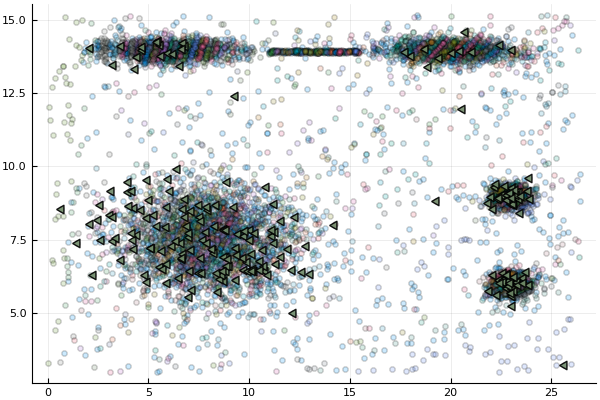

In [59]:
#results = DSNN_SNN.snn_clustering(0.9, 12, snnmat_ap);
results = DSNN_SNN.snn_clustering(0.9, 13, snn_graph);
#results = DSNN_SNN.snn_clustering(0.9, 12, snn_graph);

labels_found = fill(0, size(results["labels"],1));
for c in collect(1:size(results["labels"],2))
    for i in results["labels"][:,c].nzind
        labels_found[i] = results["clusters"][c]; # extract the right assigned label name
    end
end

# reporting results
println("Nr. of groups (+noise):",length(unique(labels_found)))
println("Nr. of corepoints:",length(results["corepoints"]))
println(Stats.countmap(labels_found))
if length(find(x->x<0, results["clusters"])) > 0
    println("Amount of noise:",round(length(results["labels"][:,1].nzind)/size(results["labels"],1),2))
else
    println("Amount of noise:0");
end
Plots.scatter(D[1,:], D[2,:], marker=(0.2,:o,4), groups=labels_found, legend=false, fmt = :png)
Plots.scatter!(D[1,results["corepoints"]], D[2,results["corepoints"]], marker=(0.9,:<,7), legend=false, fmt = :png)

Distance to k-th neighbor (from SNN similarity matrix)



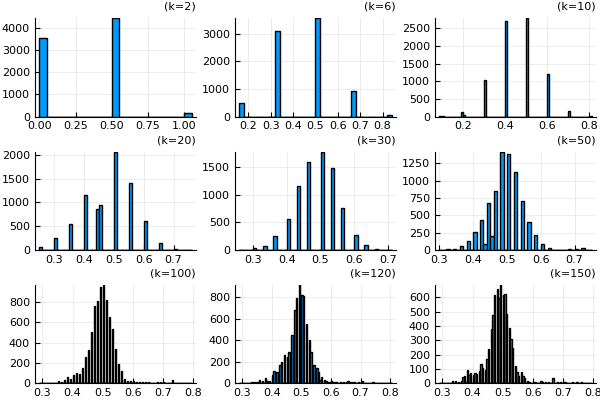

In [15]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
    kdist_arr = plot_kdist_graph(snnmat_ap, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from SNN similarity matrix)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

Distance to k-th neighbor (from filtered SNN similarity matrix)



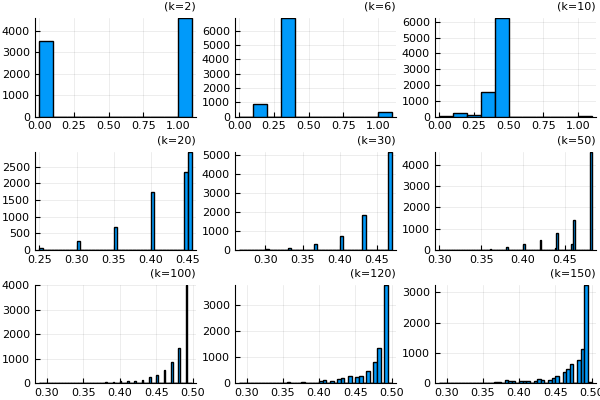

In [17]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, min_threshold=0.5, l2knng_path="/workspace/l2knng/build/knng");    
    kdist_arr = plot_kdist_graph(snnmat_ap, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from filtered SNN similarity matrix)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

Distance to k-th neighbor (from SNN Graph)



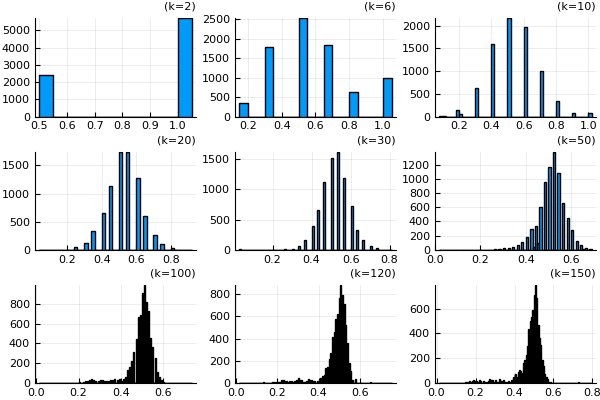

In [18]:
k_values = [2,6,10,20,30,50,100,120,150];
series = Array{Float64, 1}[];
for k in k_values
    snnmat_ap, knnmat_ap = DSNN_KNN.get_snnsimilarity(D, k, l2knng_path="/workspace/l2knng/build/knng");
    snn_graph = DSNN_KNN.get_snngraph(knnmat_ap, snnmat_ap);
    kdist_arr = plot_kdist_graph(snn_graph, k);
    push!(series, kdist_arr);
end

println("Distance to k-th neighbor (from SNN Graph)");
Plots.plot(series, layout=length(k_values), linetype=[:histogram], 
    title = ["(k=$i)" for j=1:1, i in k_values], titleloc = :right, titlefont = font(8), legend=false)

In [49]:
snn_graph

8100×8100 SparseMatrixCSC{Float64,Int64} with 376718 stored entries:
  [41  ,    1]  =  0.759999
  [94  ,    1]  =  0.819999
  [103 ,    1]  =  0.599999
  [130 ,    1]  =  0.679999
  [131 ,    1]  =  0.959998
  [237 ,    1]  =  0.779999
  [241 ,    1]  =  0.619999
  [548 ,    1]  =  0.679999
  [651 ,    1]  =  0.899999
  [800 ,    1]  =  0.659999
  ⋮
  [3349, 8100]  =  0.879983
  [3359, 8100]  =  0.639989
  [3412, 8100]  =  0.479993
  [3449, 8100]  =  0.739987
  [3531, 8100]  =  0.93998
  [3607, 8100]  =  0.679988
  [3642, 8100]  =  0.619991
  [3668, 8100]  =  0.499993
  [7104, 8100]  =  0.739987
  [7292, 8100]  =  0.719989
  [7384, 8100]  =  0.67999

In [50]:
snnmat_ap

8100×8100 SparseMatrixCSC{Float64,Int64} with 817180 stored entries:
  [1   ,    1]  =  0.999998
  [41  ,    1]  =  0.759999
  [71  ,    1]  =  0.579999
  [94  ,    1]  =  0.819999
  [103 ,    1]  =  0.599999
  [130 ,    1]  =  0.679999
  [131 ,    1]  =  0.959998
  [134 ,    1]  =  0.519998
  [169 ,    1]  =  0.279999
  [237 ,    1]  =  0.779999
  ⋮
  [3668, 8100]  =  0.499993
  [7104, 8100]  =  0.739987
  [7106, 8100]  =  0.179992
  [7173, 8100]  =  0.0999956
  [7292, 8100]  =  0.719989
  [7384, 8100]  =  0.67999
  [7617, 8100]  =  0.159994
  [7816, 8100]  =  0.43999
  [7879, 8100]  =  0.159995
  [7941, 8100]  =  0.49999
  [8100, 8100]  =  0.999977